# Imports

In [133]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt

# Graph Colors

In [195]:
colors = {
    'p': (0.459, 0.235, 0.745),
    'g': (0.827, 0.827, 0.827),
    'b': (0.137, 0.122, 0.125)
}

In [134]:
wego = pd.read_csv('../data/Headway Data, 8-1-2023 to 9-30-2023.csv')

In [135]:
wego.shape

(350329, 30)

In [4]:
wego.columns

Index(['CALENDAR_ID', 'SERVICE_ABBR', 'ADHERENCE_ID', 'DATE', 'ROUTE_ABBR',
       'BLOCK_ABBR', 'OPERATOR', 'TRIP_ID', 'OVERLOAD_ID',
       'ROUTE_DIRECTION_NAME', 'TIME_POINT_ABBR', 'ROUTE_STOP_SEQUENCE',
       'TRIP_EDGE', 'LATITUDE', 'LONGITUDE', 'SCHEDULED_TIME',
       'ACTUAL_ARRIVAL_TIME', 'ACTUAL_DEPARTURE_TIME', 'ADHERENCE',
       'SCHEDULED_HDWY', 'ACTUAL_HDWY', 'HDWY_DEV', 'ADJUSTED_EARLY_COUNT',
       'ADJUSTED_LATE_COUNT', 'ADJUSTED_ONTIME_COUNT', 'STOP_CANCELLED',
       'PREV_SCHED_STOP_CANCELLED', 'IS_RELIEF', 'DWELL_IN_MINS',
       'SCHEDULED_LAYOVER_MINUTES'],
      dtype='object')

## create unique trip id

In [186]:
def create_id(row):
    row['CALENDAR_ID'] + ''

In [187]:
wego['DATE_TRIP'] = wego.apply(lambda row: str(row['CALENDAR_ID']) + '-' + str(row['TRIP_ID']), axis=1)

In [188]:
wego['DATE_TRIP'].nunique()

67370

In [185]:
wego.groupby('DATE_TRIP').count()

KeyError: 'DATE_TRIP'

### Create Headway Categories

In [8]:
# Calculate HDWY Deviation Percentage
def get_dev_pct(row):
    '''Takes a row as input, returns a perfencate value. 
    Calculate the headway deviation percentage taking into
    consideration the possibility of SCHEDULED_HDWY being 0'''
    if row['SCHEDULED_HDWY'] != 0:
        return abs(row['HDWY_DEV']) / row['SCHEDULED_HDWY'] * 100
    else:
        return np.NaN

In [9]:
# create headway deviation percentable column
wego.loc[:, 'HDWY_DEV_PCT'] = wego.apply(lambda r: get_dev_pct(r), axis=1)

In [10]:
# Create Bunching or Gapping Indicator
def is_hdwy_bunching(dev, pct):
    if (dev < 0) & (pct > 50):
        return int(1)
    else:
        return int(0)
def is_hdwy_gapping(dev, pct):
    if (dev > 0) & (pct > 50):
        return int(1)
    else:
        return int(0)
def is_hdwy_acceptable(pct):
    if pct <= 50:
        return int(1)
    else:
        return int(0)

In [11]:
# Create new Bunching/gapping columns with Boolean values for each group.
wego.loc[:, 'HDWY_BUNCHING'] = wego.apply(lambda r: 
                                          is_hdwy_bunching(r['HDWY_DEV'], r['HDWY_DEV_PCT']), axis=1)
wego.loc[:, 'HDWY_ACCEPTABLE'] = wego.apply(lambda r: 
                                            is_hdwy_acceptable(r['HDWY_DEV_PCT']), axis=1)
wego.loc[:, 'HDWY_GAPPING'] = wego.apply(lambda r: 
                                         is_hdwy_gapping(r['HDWY_DEV'], r['HDWY_DEV_PCT']), axis=1)

# 1) What is the overall on-time performance, and what do the overall distributions of adherence and headway deviation look like? 

In [12]:
round(wego['ADJUSTED_ONTIME_COUNT'].value_counts()[1] / wego.shape[0] * 100, 2)

77.08

#### 77% of checkins here considered ontime.

In [13]:
trips_adherence_cat = (wego.groupby('DATE_TRIP')
.sum()
[['ADJUSTED_EARLY_COUNT', 'ADJUSTED_LATE_COUNT', 'ADJUSTED_ONTIME_COUNT']])

In [14]:
perfect_trips = (trips_adherence_cat[
    (trips_adherence_cat['ADJUSTED_EARLY_COUNT'] == 0) & 
    (trips_adherence_cat['ADJUSTED_LATE_COUNT'] == 0)])

In [15]:
round(perfect_trips.shape[0] / trips_adherence_cat.shape[0] * 100, 2)

60.62

In [16]:
perfect_trips.shape[0]

40843

#### 60.6% of all trips were perfect, 40843 perfect trips

In [17]:
wego['ADHERENCE'].apply(['min', 'max', 'mean', 'median'])

min      -948.533333
max        88.383333
mean       -3.188796
median     -2.000000
Name: ADHERENCE, dtype: float64

In [18]:
wego['HDWY_DEV'].apply(['min', 'max', 'mean', 'median'])

min       -64.000000
max       565.433333
mean        0.518081
median      0.033333
Name: HDWY_DEV, dtype: float64

In [19]:
# Calculate Adherence mean and standard deviation
ad_mean = wego['ADHERENCE'].mean()
ad_std = np.std(wego['ADHERENCE'])

[Text(0.5, 1.0, 'Adherence Distribution Excluding Outliers'),
 Text(0.5, 0, 'Adherence')]

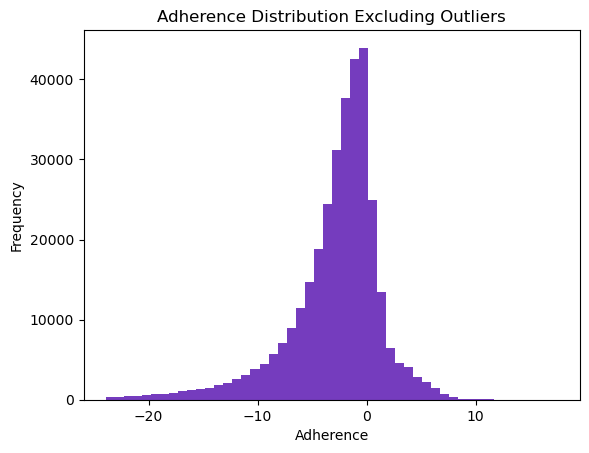

In [192]:
ax = (
    wego[wego['ADHERENCE'].between(ad_mean - ad_std*3,
                                   ad_mean + ad_std*3,
                                   inclusive='both')]
    ['ADHERENCE']
    .plot(kind='hist',
          bins=50, color= [colors['p']])
)

ax.set(
    title='Adherence Distribution Excluding Outliers',
    xlabel='Adherence'
    )

In [21]:
# Calculate Headway Deviation mean and standard deviation
hd_mean = wego['HDWY_DEV'].mean()
hd_std = np.std(wego['HDWY_DEV'])

[Text(0.5, 1.0, 'Headway Deviation Distribution Excluding Outliers'),
 Text(0.5, 0, 'Headway Deviation')]

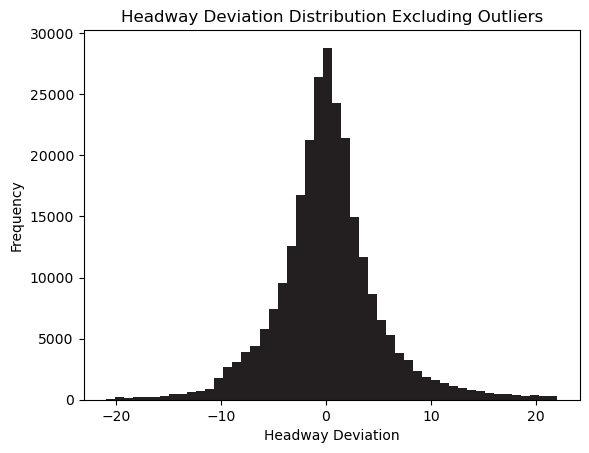

In [196]:
ax= (
    wego[wego['HDWY_DEV'].between(hd_mean - hd_std*3, 
                                  hd_mean + hd_std*3, 
                                  inclusive='both')]
    ['HDWY_DEV']
    .plot(kind='hist', bins=50, color= [colors['b']])
)

ax.set(
    title='Headway Deviation Distribution Excluding Outliers',
    xlabel='Headway Deviation'
    )

# 2) How does direction of travel, route, or location affect the headway and on-time performance?

In [23]:
wego.columns

Index(['CALENDAR_ID', 'SERVICE_ABBR', 'ADHERENCE_ID', 'DATE', 'ROUTE_ABBR',
       'BLOCK_ABBR', 'OPERATOR', 'TRIP_ID', 'OVERLOAD_ID',
       'ROUTE_DIRECTION_NAME', 'TIME_POINT_ABBR', 'ROUTE_STOP_SEQUENCE',
       'TRIP_EDGE', 'LATITUDE', 'LONGITUDE', 'SCHEDULED_TIME',
       'ACTUAL_ARRIVAL_TIME', 'ACTUAL_DEPARTURE_TIME', 'ADHERENCE',
       'SCHEDULED_HDWY', 'ACTUAL_HDWY', 'HDWY_DEV', 'ADJUSTED_EARLY_COUNT',
       'ADJUSTED_LATE_COUNT', 'ADJUSTED_ONTIME_COUNT', 'STOP_CANCELLED',
       'PREV_SCHED_STOP_CANCELLED', 'IS_RELIEF', 'DWELL_IN_MINS',
       'SCHEDULED_LAYOVER_MINUTES', 'DATE_TRIP', 'HDWY_DEV_PCT',
       'HDWY_BUNCHING', 'HDWY_ACCEPTABLE', 'HDWY_GAPPING'],
      dtype='object')

### Route Direction

#### Headway

In [24]:
# Create new df for Headway columns grouped by Route Direction
route_direction_totals = (
    wego.groupby('ROUTE_DIRECTION_NAME')
         [['HDWY_BUNCHING', 'HDWY_ACCEPTABLE', 'HDWY_GAPPING']]
         .sum()
)

In [25]:
# Create new total column for each row
route_direction_totals['TOTALS'] = route_direction_totals.sum(axis=1)

In [26]:
# Create new percentage column for each category
route_direction_totals.loc[:, 'BUNCHING_PCT'] = (route_direction_totals['HDWY_BUNCHING'] / 
                                                route_direction_totals['TOTALS'] * 100)
route_direction_totals.loc[:, 'ACCEPTABLE_PCT'] = (route_direction_totals['HDWY_ACCEPTABLE'] / 
                                                    route_direction_totals['TOTALS'] * 100)
route_direction_totals.loc[:, 'GAPPING_PCT'] = (route_direction_totals['HDWY_GAPPING'] / 
                                                    route_direction_totals['TOTALS'] * 100)

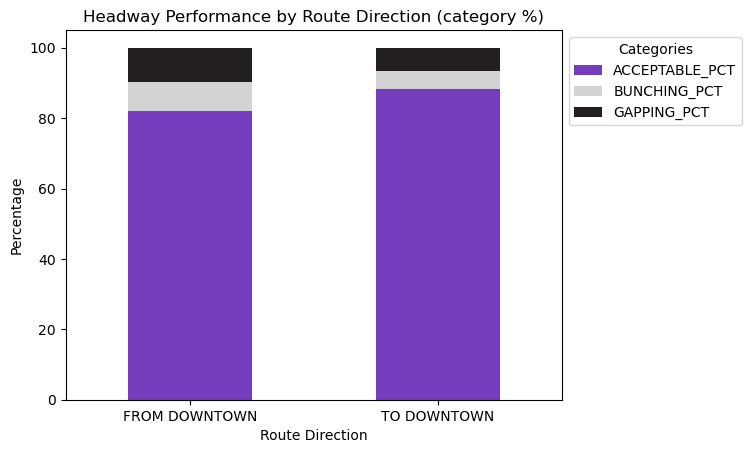

In [198]:
# Route Direction Headway Graph
ax = (route_direction_totals[['ACCEPTABLE_PCT', 'BUNCHING_PCT', 'GAPPING_PCT']]
      .plot(kind='bar',
            stacked=True,
           color= [colors['p'], colors['g'], colors['b']]))

ax.set(title = 'Headway Performance by Route Direction (category %)',
        xlabel = 'Route Direction',
       ylabel = 'Percentage')
ax.legend(title = 'Categories', bbox_to_anchor=(1, 1))
ax.tick_params(axis='x', rotation=0)

#### Adherence

In [28]:
# Create new df for Headway columns grouped by Route Direction
route_ad_direction_totals = (
    wego.groupby('ROUTE_DIRECTION_NAME')
         [['ADJUSTED_ONTIME_COUNT', 'ADJUSTED_LATE_COUNT', 'ADJUSTED_EARLY_COUNT']]
         .sum()
)

In [29]:
# Create new total column for each row
route_ad_direction_totals['TOTALS'] = route_ad_direction_totals.sum(axis=1)

In [30]:
# Create new percentage column for each category
route_ad_direction_totals.loc[:, 'ONTIME_PCT'] = (route_ad_direction_totals['ADJUSTED_ONTIME_COUNT'] / 
                                                  route_ad_direction_totals['TOTALS'] * 100)
route_ad_direction_totals.loc[:, 'EARLY_PCT'] = (route_ad_direction_totals['ADJUSTED_EARLY_COUNT'] / 
                                                 route_ad_direction_totals['TOTALS'] * 100)
route_ad_direction_totals.loc[:, 'LATE_PCT'] = (route_ad_direction_totals['ADJUSTED_LATE_COUNT'] / 
                                                  route_ad_direction_totals['TOTALS'] * 100)

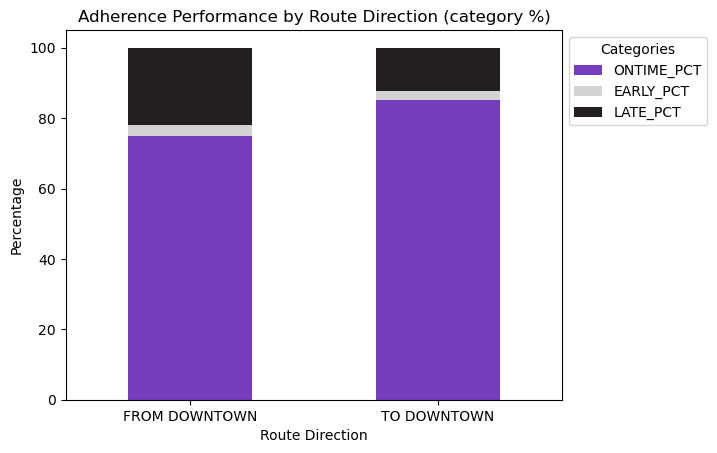

In [199]:
# Route Direction Adherence graph
ax = (
    route_ad_direction_totals[['ONTIME_PCT', 'EARLY_PCT', 'LATE_PCT']]
).plot(kind='bar',
       stacked=True,
      color= [colors['p'], colors['g'], colors['b']])
ax.set(title = 'Adherence Performance by Route Direction (category %)',
        xlabel = 'Route Direction',
       ylabel = 'Percentage')
ax.legend(title = 'Categories', bbox_to_anchor=(1, 1))
ax.tick_params(axis='x', rotation=0)

In [32]:
wego.groupby('ROUTE_DIRECTION_NAME')[['HDWY_DEV_PCT', 'ADHERENCE']].mean()

,HDWY_DEV_PCT,ADHERENCE
ROUTE_DIRECTION_NAME,,
FROM DOWNTOWN,29.216261,-3.960287
TO DOWNTOWN,22.179487,-2.321804


#### TO DOWNTOWN direction has a slightly better Headway Deviation and Adherence performance

### ROUTE Performance

In [33]:
wego.groupby('ROUTE_ABBR')[['ADHERENCE', 'HDWY_DEV']].mean()

,ADHERENCE,HDWY_DEV
ROUTE_ABBR,,
3,-3.761491,0.580907
7,-3.346555,0.336808
22,-1.138107,0.955867
23,-1.760110,1.053563
50,-2.505022,0.212376
52,-3.971342,0.974776
55,-4.823302,0.261038
56,-2.703988,0.149213


#### Route 22 has better overall Adherence while route 56 has better headway deviation

### Route Adherence

In [34]:
# Create new df for Adherence columns grouped by Route
routes_totals = (
    wego.groupby('ROUTE_ABBR')
         [['ADJUSTED_ONTIME_COUNT', 'ADJUSTED_LATE_COUNT', 'ADJUSTED_EARLY_COUNT']]
         .sum()
)

In [35]:
# Create new total column for each row
routes_totals['TOTALS'] = routes_totals.sum(axis=1)

In [36]:
# Create new percentage column for each category
routes_totals.loc[:, 'ONTIME_PCT'] = routes_totals['ADJUSTED_ONTIME_COUNT'] / routes_totals['TOTALS'] * 100
routes_totals.loc[:, 'EARLY_PCT'] = routes_totals['ADJUSTED_EARLY_COUNT'] / routes_totals['TOTALS'] * 100
routes_totals.loc[:, 'LATE_PCT'] = routes_totals['ADJUSTED_LATE_COUNT'] / routes_totals['TOTALS'] * 100

In [37]:
routes_totals

,ADJUSTED_ONTIME_COUNT,ADJUSTED_LATE_COUNT,ADJUSTED_EARLY_COUNT,TOTALS,ONTIME_PCT,EARLY_PCT,LATE_PCT
ROUTE_ABBR,,,,,,,
3,34516,9590,1382,45488,75.879353,3.038164,21.082483
7,13417,3417,433,17267,77.703133,2.507674,19.789193
22,22492,2065,631,25188,89.296490,2.505161,8.198348
23,35137,3230,1286,39653,88.611202,3.243134,8.145664
50,36309,5113,1207,42629,85.174412,2.831406,11.994182
52,37736,10038,1553,49327,76.501713,3.148377,20.349910
55,42080,16748,1531,60359,69.716198,2.536490,27.747312
56,48361,8837,1752,58950,82.037320,2.972010,14.990670


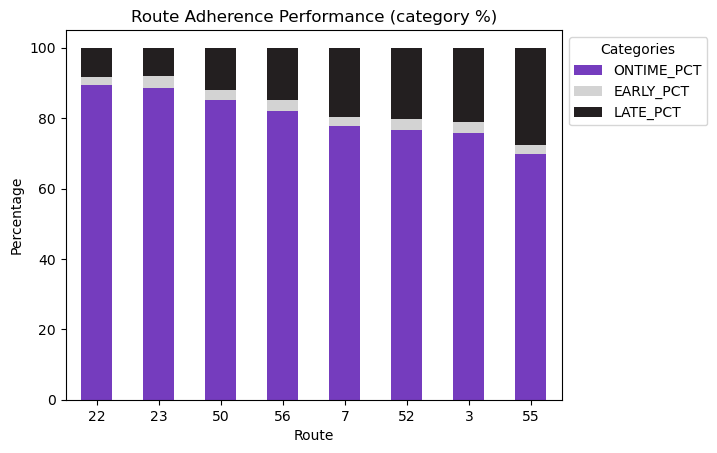

In [200]:
# Route Adherence graph
ax = (routes_totals[['ONTIME_PCT', 'EARLY_PCT', 'LATE_PCT']]
).sort_values('ONTIME_PCT', ascending=False).plot(kind='bar',
                                                  stacked=True,
                                                 color= [colors['p'], colors['g'], colors['b']])
ax.set(title = 'Route Adherence Performance (category %)',
        xlabel = 'Route',
       ylabel = 'Percentage')
ax.legend(bbox_to_anchor=(1, 1), title='Categories')
ax.tick_params(axis='x', rotation=0)

### Route Headway

In [39]:
# Create new df for Headway columns grouped by Route
routes_hdwy_totals = (
    wego.groupby('ROUTE_ABBR')
         [['HDWY_BUNCHING', 'HDWY_ACCEPTABLE', 'HDWY_GAPPING']]
         .sum()
)

In [40]:
# Create new total column for each row
routes_hdwy_totals['TOTALS'] = routes_hdwy_totals.sum(axis=1)

In [41]:
# Create new percentage column for each category
routes_hdwy_totals.loc[:, 'BUNCHING_PCT'] = routes_hdwy_totals['HDWY_BUNCHING'] / routes_hdwy_totals['TOTALS'] * 100
routes_hdwy_totals.loc[:, 'ACCEPTABLE_PCT'] = routes_hdwy_totals['HDWY_ACCEPTABLE'] / routes_hdwy_totals['TOTALS'] * 100
routes_hdwy_totals.loc[:, 'GAPPING_PCT'] = routes_hdwy_totals['HDWY_GAPPING'] / routes_hdwy_totals['TOTALS'] * 100

In [42]:
routes_hdwy_totals

,HDWY_BUNCHING,HDWY_ACCEPTABLE,HDWY_GAPPING,TOTALS,BUNCHING_PCT,ACCEPTABLE_PCT,GAPPING_PCT
ROUTE_ABBR,,,,,,,
3,2179,31460,2944,36583,5.956319,85.996228,8.047454
7,463,10500,615,11578,3.998964,90.689238,5.311798
22,297,15971,739,17007,1.746340,93.908391,4.345270
23,730,25802,1946,28478,2.563382,90.603273,6.833345
50,1056,32129,1397,34582,3.053612,92.906714,4.039674
52,3009,33050,3828,39887,7.543811,82.859077,9.597112
55,6569,36379,6468,49416,13.293265,73.617857,13.088878
56,3696,40627,3993,48316,7.649640,84.086017,8.264343


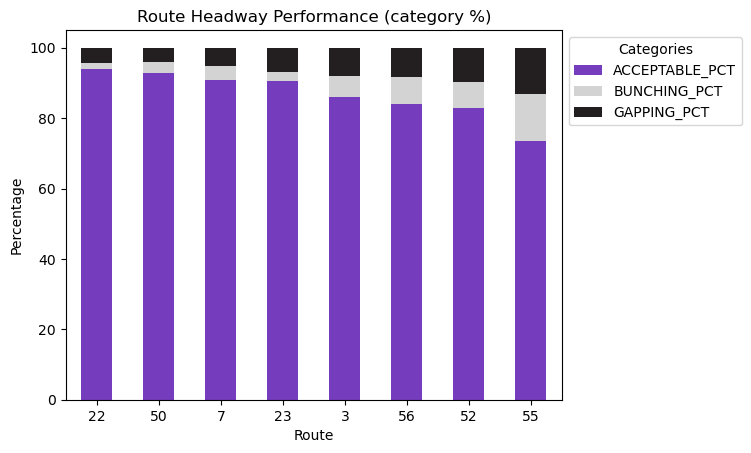

In [201]:
# Route Headway graph
ax = (routes_hdwy_totals[['ACCEPTABLE_PCT', 'BUNCHING_PCT', 'GAPPING_PCT']]
).sort_values('ACCEPTABLE_PCT', ascending=False).plot(kind='bar',
                                                      stacked=True,
                                                     color= [colors['p'], colors['g'], colors['b']])
ax.set(title = 'Route Headway Performance (category %)',
        xlabel = 'Route',
       ylabel = 'Percentage')
ax.legend(bbox_to_anchor=(1, 1), title='Categories')
ax.tick_params(axis='x', rotation=0)

### Adherence by location

In [44]:
wego.groupby('TIME_POINT_ABBR')[['ADHERENCE', 'HDWY_DEV']].mean().sort_values('ADHERENCE', ascending=True)

,ADHERENCE,HDWY_DEV
TIME_POINT_ABBR,,
MCC5_11,-37.570714,NaN
MCC4_20,-13.356229,NaN
MCC5_12,-9.785042,NaN
MCC5_7,-9.075463,NaN
DCSCC,-7.091481,12.054055
...,...,...
HEAD,1.013657,NaN
MCC5_2,1.252623,NaN
25ACLARK,1.458553,0.551163


In [45]:
# Create new df for Adherence columns grouped by Location
location_totals = (
    wego.groupby('TIME_POINT_ABBR')
         [['ADJUSTED_ONTIME_COUNT', 'ADJUSTED_LATE_COUNT', 'ADJUSTED_EARLY_COUNT']]
         .sum()
)

In [46]:
# Create new total column for each row
location_totals['TOTALS'] = location_totals.sum(axis=1)

In [47]:
# Create new percentage column for each category
location_totals.loc[:, 'ONTIME_PCT'] = location_totals['ADJUSTED_ONTIME_COUNT'] / location_totals['TOTALS'] * 100
location_totals.loc[:, 'EARLY_PCT'] = location_totals['ADJUSTED_EARLY_COUNT'] / location_totals['TOTALS'] * 100
location_totals.loc[:, 'LATE_PCT'] = location_totals['ADJUSTED_LATE_COUNT'] / location_totals['TOTALS'] * 100

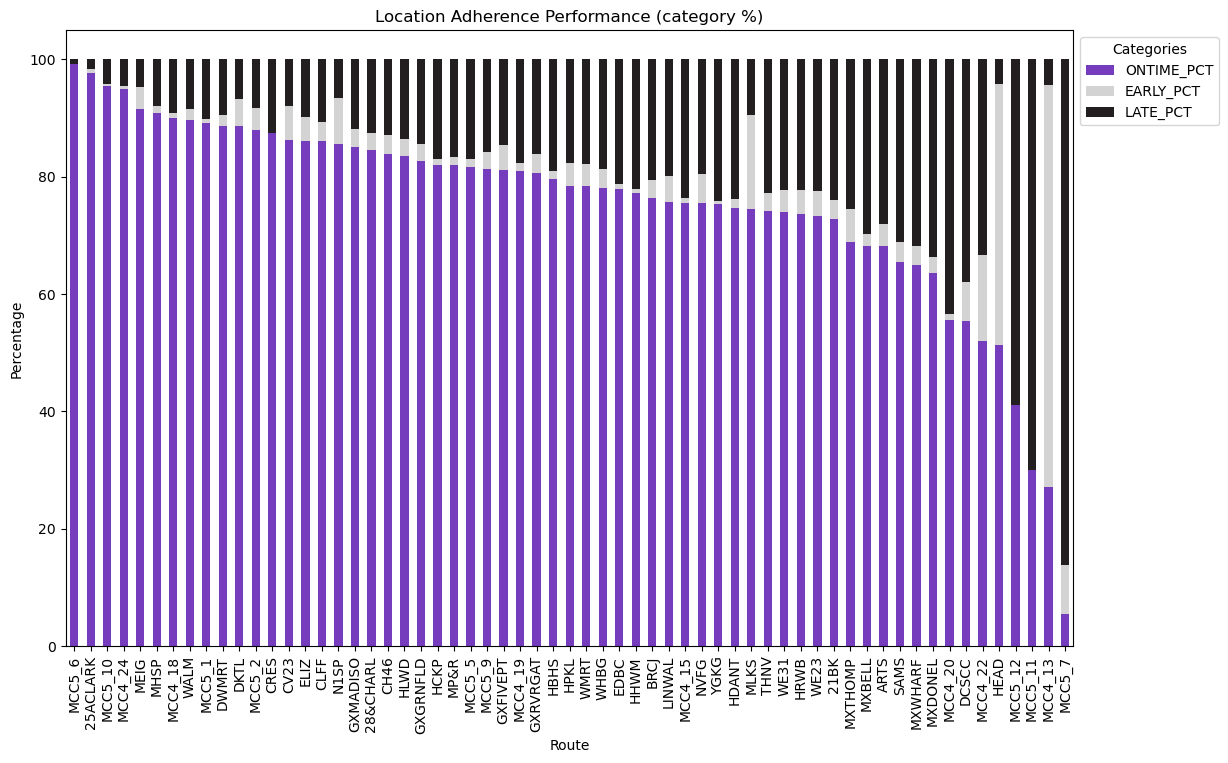

In [202]:
# Location Adherence graph
ax = (location_totals[['ONTIME_PCT', 'EARLY_PCT', 'LATE_PCT']]
).sort_values('ONTIME_PCT', ascending=False).plot(kind='bar',
                                                  stacked=True, 
                                                  figsize=(13, 8),
                                                 color= [colors['p'], colors['g'], colors['b']])
ax.set(title = 'Location Adherence Performance (category %)',
        xlabel = 'Route',
       ylabel = 'Percentage')
ax.legend(bbox_to_anchor=(1, 1), title='Categories')
# ax.tick_params(axis='x', rotation=0)

### Headway by Location

In [49]:
# Create new df for Headway columns grouped by Location
location_hdwy_totals = (
    wego.groupby('TIME_POINT_ABBR')
         [['HDWY_BUNCHING', 'HDWY_ACCEPTABLE', 'HDWY_GAPPING']]
         .sum()
)

In [50]:
# Create new total column for each row
location_hdwy_totals['TOTALS'] = location_hdwy_totals.sum(axis=1)

In [51]:
# Create new percentage column for each category
location_hdwy_totals.loc[:, 'BUNCHING_PCT'] = location_hdwy_totals['HDWY_BUNCHING'] / location_hdwy_totals['TOTALS'] * 100
location_hdwy_totals.loc[:, 'ACCEPTABLE_PCT'] = location_hdwy_totals['HDWY_ACCEPTABLE'] / location_hdwy_totals['TOTALS'] * 100
location_hdwy_totals.loc[:, 'GAPPING_PCT'] = location_hdwy_totals['HDWY_GAPPING'] / location_hdwy_totals['TOTALS'] * 100

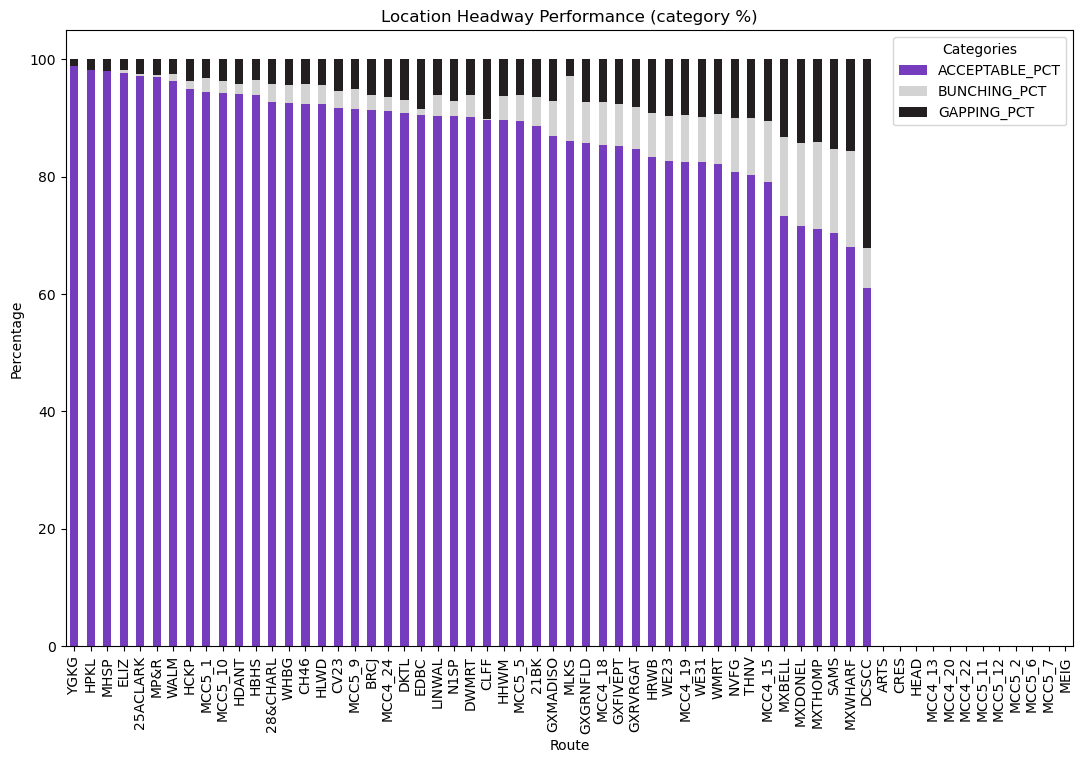

In [203]:
# Location Adherence graph
ax = (location_hdwy_totals[['ACCEPTABLE_PCT', 'BUNCHING_PCT', 'GAPPING_PCT']]
            .sort_values('ACCEPTABLE_PCT', ascending=False)
            .plot(kind='bar', 
                  stacked=True, 
                  figsize=(13, 8),
                 color= [colors['p'], colors['g'], colors['b']]))
    
ax.set(title = 'Location Headway Performance (category %)',
        xlabel = 'Route',
       ylabel = 'Percentage')
ax.legend(bbox_to_anchor=(1, 1), title='Categories')
# ax.tick_params(axis='x', rotation=0)

# 3) How does time of day or day of week affect headway and on-time performance?

#### Box plots?

In [55]:
# Drop na depart times
clean_dept_time = wego.dropna(subset=['ACTUAL_DEPARTURE_TIME'])

In [56]:
clean_dept_time['HOUR'] = (pd.to_datetime(clean_dept_time['ACTUAL_DEPARTURE_TIME'],
                                          format='mixed').dt.hour)

C:\Users\derek\AppData\Local\Temp\ipykernel_23704\1395973387.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean_dept_time['HOUR'] = (pd.to_datetime(clean_dept_time['ACTUAL_DEPARTURE_TIME'],


In [57]:
clean_dept_time.groupby('HOUR')[['ADHERENCE', 'HDWY_DEV']].mean()

,ADHERENCE,HDWY_DEV
HOUR,,
0,-4.478019,0.905051
1,-10.618182,4.021621
4,-0.785533,-0.771043
5,-0.966710,0.306431
6,-1.501108,0.347326
7,-2.691298,0.700018
8,-3.758128,0.413859
9,-2.611876,0.265547
10,-2.117932,0.314521


### Adherence by Hour

In [58]:
# Create new df for Adherence columns grouped by Hour
hour_totals = (
    clean_dept_time.groupby('HOUR')
         [['ADJUSTED_ONTIME_COUNT', 'ADJUSTED_LATE_COUNT', 'ADJUSTED_EARLY_COUNT']]
         .sum()
)


In [59]:
# Create new total column for each row
hour_totals['TOTALS'] = hour_totals.sum(axis=1)

In [60]:
# Create new percentage column for each category
hour_totals.loc[:, 'ONTIME_PCT'] = hour_totals['ADJUSTED_ONTIME_COUNT'] / hour_totals['TOTALS'] * 100
hour_totals.loc[:, 'EARLY_PCT'] = hour_totals['ADJUSTED_EARLY_COUNT'] / hour_totals['TOTALS'] * 100
hour_totals.loc[:, 'LATE_PCT'] = hour_totals['ADJUSTED_LATE_COUNT'] / hour_totals['TOTALS'] * 100

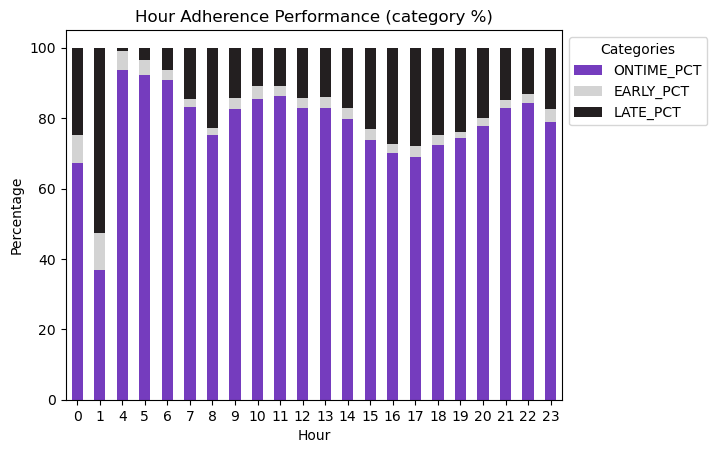

In [204]:
# Hour Adherence graph
ax = (hour_totals[['ONTIME_PCT', 'EARLY_PCT', 'LATE_PCT']]
).plot(kind='bar',
       stacked=True,
      color= [colors['p'], colors['g'], colors['b']])
ax.set(title = 'Hour Adherence Performance (category %)',
        xlabel = 'Hour',
       ylabel = 'Percentage')
ax.legend(bbox_to_anchor=(1, 1), title='Categories')
ax.tick_params(axis='x', rotation=0)

### Headway by Hour

In [62]:
# Create new df for Headway columns grouped by Hour
hour_hdwy_totals = (
    clean_dept_time.groupby('HOUR')
         [['HDWY_BUNCHING', 'HDWY_ACCEPTABLE', 'HDWY_GAPPING']]
         .sum()
)

In [63]:
# Create new total column for each row
hour_hdwy_totals['TOTALS'] = hour_hdwy_totals.sum(axis=1)

In [64]:
# Create new percentage column for each category
hour_hdwy_totals.loc[:, 'BUNCHING_PCT'] = hour_hdwy_totals['HDWY_BUNCHING'] / hour_hdwy_totals['TOTALS'] * 100
hour_hdwy_totals.loc[:, 'ACCEPTABLE_PCT'] = hour_hdwy_totals['HDWY_ACCEPTABLE'] / hour_hdwy_totals['TOTALS'] * 100
hour_hdwy_totals.loc[:, 'GAPPING_PCT'] = hour_hdwy_totals['HDWY_GAPPING'] / hour_hdwy_totals['TOTALS'] * 100

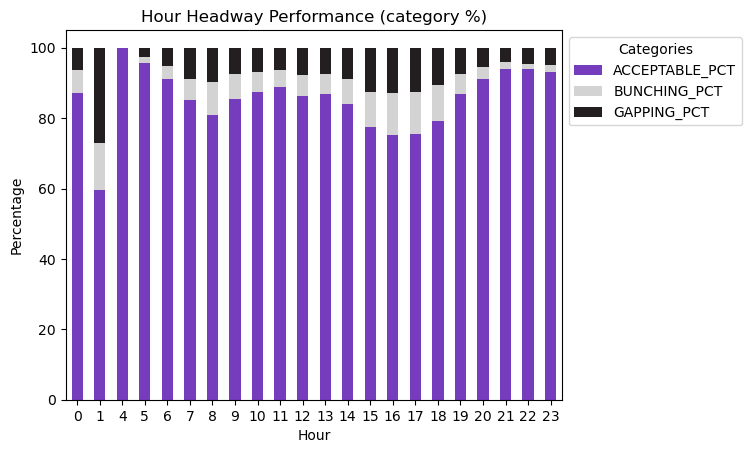

In [205]:
# Hour Headway graph
ax = (hour_hdwy_totals[['ACCEPTABLE_PCT', 'BUNCHING_PCT', 'GAPPING_PCT']]
).plot(kind='bar',
       stacked=True,
      color= [colors['p'], colors['g'], colors['b']])
ax.set(title = 'Hour Headway Performance (category %)',
        xlabel = 'Hour',
       ylabel = 'Percentage')
ax.legend(bbox_to_anchor=(1, 1), title='Categories')
ax.tick_params(axis='x', rotation=0)

## Weekday

#### Monday is 0

In [66]:
# Create Weekday column
clean_dept_time['WEEKDAY'] = pd.to_datetime(clean_dept_time['ACTUAL_DEPARTURE_TIME']).dt.weekday

C:\Users\derek\AppData\Local\Temp\ipykernel_23704\3419957694.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean_dept_time['WEEKDAY'] = pd.to_datetime(clean_dept_time['ACTUAL_DEPARTURE_TIME']).dt.weekday


In [67]:
# use Grouper to group by Weekday
wego_by_day = (clean_dept_time.groupby(pd.Grouper(key='WEEKDAY')))

## Adherence by Weekday

In [68]:
# Create new df for Adherence columns grouped by Weekday
weekday_totals = (
    wego_by_day
         [['ADJUSTED_ONTIME_COUNT', 'ADJUSTED_LATE_COUNT', 'ADJUSTED_EARLY_COUNT']]
         .sum()
)

In [69]:
# Create new total column for each row
weekday_totals['TOTALS'] = weekday_totals.sum(axis=1)

In [70]:
# Create new percentage column for each category
weekday_totals.loc[:, 'ONTIME_PCT'] = weekday_totals['ADJUSTED_ONTIME_COUNT'] / weekday_totals['TOTALS'] * 100
weekday_totals.loc[:, 'EARLY_PCT'] = weekday_totals['ADJUSTED_EARLY_COUNT'] / weekday_totals['TOTALS'] * 100
weekday_totals.loc[:, 'LATE_PCT'] = weekday_totals['ADJUSTED_LATE_COUNT'] / weekday_totals['TOTALS'] * 100

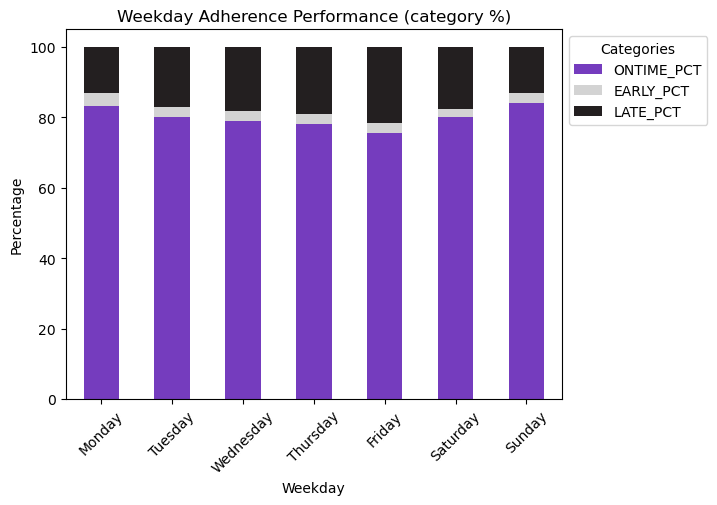

In [206]:
# Hour Adherence graph
ax = (weekday_totals[['ONTIME_PCT', 'EARLY_PCT', 'LATE_PCT']]
                ).sort_index().plot(kind='bar', 
                                    stacked=True,
                                   color= [colors['p'], colors['g'], colors['b']])

ax.set(title = 'Weekday Adherence Performance (category %)',
        xlabel = 'Weekday',
       ylabel = 'Percentage')
ax.legend(bbox_to_anchor=(1, 1), title='Categories')
ax.set_xticklabels(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
ax.tick_params(axis='x', rotation=45)

### Headway by Weekday

In [72]:
# Create new df for Headway columns grouped by Weekday
weekday_hdwy_totals = (
    wego_by_day
         [['HDWY_BUNCHING', 'HDWY_ACCEPTABLE', 'HDWY_GAPPING']]
         .sum()
)

In [73]:
# Create new total column for each row
weekday_hdwy_totals['TOTALS'] = weekday_hdwy_totals.sum(axis=1)

In [74]:
weekday_hdwy_totals

,HDWY_BUNCHING,HDWY_ACCEPTABLE,HDWY_GAPPING,TOTALS
WEEKDAY,,,,
1,3221,37104,3806,44131
3,3532,36391,4278,44201
2,3447,37217,3934,44598
4,3986,35014,4867,43867
5,985,26137,1364,28486
6,546,21134,1094,22774
0,2282,32921,2587,37790


In [75]:
# Create new percentage column for each category
weekday_hdwy_totals.loc[:, 'BUNCHING_PCT'] = weekday_hdwy_totals['HDWY_BUNCHING'] / weekday_hdwy_totals['TOTALS'] * 100
weekday_hdwy_totals.loc[:, 'ACCEPTABLE_PCT'] = weekday_hdwy_totals['HDWY_ACCEPTABLE'] / weekday_hdwy_totals['TOTALS'] * 100
weekday_hdwy_totals.loc[:, 'GAPPING_PCT'] = weekday_hdwy_totals['HDWY_GAPPING'] / weekday_hdwy_totals['TOTALS'] * 100

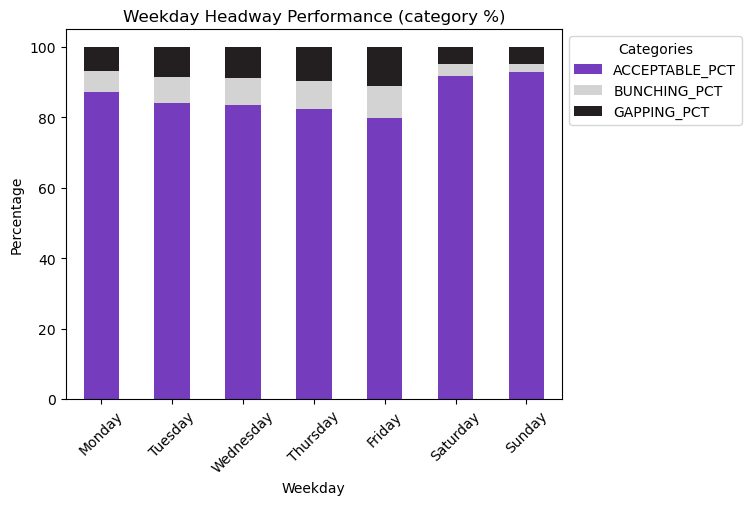

In [207]:
# Hour Adherence graph
ax = (weekday_hdwy_totals[['ACCEPTABLE_PCT', 'BUNCHING_PCT', 'GAPPING_PCT']]
                ).sort_index().plot(kind='bar',
                                    stacked=True,
                                   color= [colors['p'], colors['g'], colors['b']])

ax.set(title = 'Weekday Headway Performance (category %)',
        xlabel = 'Weekday',
       ylabel = 'Percentage')
ax.legend(bbox_to_anchor=(1, 1), title='Categories')
ax.set_xticklabels(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
ax.tick_params(axis='x', rotation=45)

#### No trips were made during the hours of 2 and 3

# 4) How much of a factor does the driver have on headway and on-time performance? The driver is indicated by the OPERATOR variable.

### Adherence by Operpator

In [77]:
# Create new df for Adherence columns grouped by Operator
operator_totals = (
    wego.groupby('OPERATOR')
         [['ADJUSTED_ONTIME_COUNT', 'ADJUSTED_LATE_COUNT',
           'ADJUSTED_EARLY_COUNT', 'HDWY_BUNCHING',
           'HDWY_ACCEPTABLE', 'HDWY_GAPPING']]
         .sum()
)

In [78]:
# Create new total column for each row
operator_totals['ADH_TOTALS'] = (operator_totals[['ADJUSTED_ONTIME_COUNT', 'ADJUSTED_LATE_COUNT',
           'ADJUSTED_EARLY_COUNT']].sum(axis=1))
operator_totals['HDWY_TOTALS'] = (operator_totals[['HDWY_BUNCHING',
           'HDWY_ACCEPTABLE', 'HDWY_GAPPING']].sum(axis=1))

In [79]:
# Create new percentage column for each category
operator_totals.loc[:, 'ONTIME_PCT'] = round(operator_totals['ADJUSTED_ONTIME_COUNT'] / 
                                             operator_totals['ADH_TOTALS'] * 100, 1)
operator_totals.loc[:, 'EARLY_PCT'] = round(operator_totals['ADJUSTED_EARLY_COUNT'] /
                                            operator_totals['ADH_TOTALS'] * 100, 1)
operator_totals.loc[:, 'LATE_PCT'] = round(operator_totals['ADJUSTED_LATE_COUNT'] /
                                           operator_totals['ADH_TOTALS'] * 100, 1)
operator_totals.loc[:, 'BUNCHING_PCT'] = round(operator_totals['HDWY_BUNCHING'] /
                                               operator_totals['HDWY_TOTALS'] * 100, 1)
operator_totals.loc[:, 'ACCEPTABLE_PCT'] = round(operator_totals['HDWY_ACCEPTABLE'] /
                                                 operator_totals['HDWY_TOTALS'] * 100, 1)
operator_totals.loc[:, 'GAPPING_PCT'] = round(operator_totals['HDWY_GAPPING'] /
                                              operator_totals['HDWY_TOTALS'] * 100, 1)

In [89]:
operator_summary = operator_totals[['ADH_TOTALS', 'HDWY_TOTALS', 'ONTIME_PCT', 'ACCEPTABLE_PCT']]

In [90]:
operator_summary

,ADH_TOTALS,HDWY_TOTALS,ONTIME_PCT,ACCEPTABLE_PCT
OPERATOR,,,,
0,1,0,100.0,NaN
56,3,2,100.0,100.0
235,12,9,50.0,77.8
244,25,20,80.0,65.0
301,37,30,51.4,53.3
...,...,...,...,...
3149,88,56,86.4,92.9
3156,290,230,75.5,95.7
3165,32,24,37.5,66.7


In [229]:
top20_adh = (
    operator_summary
            .loc[operator_totals['ADH_TOTALS'] >= 1000]
            .nlargest(20, columns=['ONTIME_PCT', 'ADH_TOTALS'])
)

In [231]:
bottom20_adh = (
    operator_summary
            .loc[operator_totals['ADH_TOTALS'] >= 1000]
            .nsmallest(20, columns=['ONTIME_PCT', 'ADH_TOTALS'])
)

In [232]:
top20_hdwy = (
    operator_summary
            .loc[operator_totals['HDWY_TOTALS'] >= 1000]
            .nlargest(20, columns=['ACCEPTABLE_PCT', 'HDWY_TOTALS'])
)

In [233]:
bottom20_hdwy = (
    operator_summary
            .loc[operator_totals['HDWY_TOTALS'] >= 1000]
            .nsmallest(20, columns=['ACCEPTABLE_PCT', 'HDWY_TOTALS'])
)

In [234]:
# join TOP dfs on operator
top_operators = (pd.merge(top20_adh, 
                          top20_hdwy[[]], 
                          how='inner', 
                          left_index=True, 
                          right_index=True))
top_operators

,ADH_TOTALS,HDWY_TOTALS,ONTIME_PCT,ACCEPTABLE_PCT
OPERATOR,,,,
1762,2333,1553,98.3,91.4
409,2380,1715,97.1,96.6
1566,2200,1835,97.0,98.0
1927,2413,1960,96.0,95.4
1040,1770,1058,95.8,97.4
1133,2625,2177,95.4,93.6
1617,1806,1281,95.3,97.2
2321,1420,1180,94.0,93.7
2088,2021,1528,92.8,94.1


In [235]:
# join BOTTOM dfs on operator
bottom_operators = (pd.merge(bottom20_adh, 
                             bottom20_hdwy[[]], 
                             how='inner', 
                             left_index=True, 
                             right_index=True))
bottom_operators

,ADH_TOTALS,HDWY_TOTALS,ONTIME_PCT,ACCEPTABLE_PCT
OPERATOR,,,,
3101,1297,1055,44.6,73.0
1800,1625,1298,48.6,73.8
2109,2093,1707,54.4,68.8
357,1584,1204,54.7,75.6
1352,1693,1412,56.3,63.5
1277,1375,1075,57.8,74.8
2356,1408,1105,58.2,69.0
2082,1759,1460,58.4,70.8
1359,1548,1289,59.6,65.4


In [236]:
top_bottom_operators = pd.concat([top_operators, bottom_operators.sort_values('ONTIME_PCT', ascending=False)])
top_bottom_operators

,ADH_TOTALS,HDWY_TOTALS,ONTIME_PCT,ACCEPTABLE_PCT
OPERATOR,,,,
1762,2333,1553,98.3,91.4
409,2380,1715,97.1,96.6
1566,2200,1835,97.0,98.0
1927,2413,1960,96.0,95.4
1040,1770,1058,95.8,97.4
1133,2625,2177,95.4,93.6
1617,1806,1281,95.3,97.2
2321,1420,1180,94.0,93.7
2088,2021,1528,92.8,94.1


In [252]:
# Creat new column for negative Headway
top_bottom_operators.loc[:, 'NEGATIVE_ACCEPTABLE'] = top_bottom_operators['ACCEPTABLE_PCT'].apply(lambda pct: -pct)

In [248]:
# function to correct negative 
def get_label_value(num):
    if num >= 0:
        return str(num) + '%'
    else:
        return str(-num) +'%'

C:\Users\derek\AppData\Local\Temp\ipykernel_23704\1531222343.py:28: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['', '100%', '75%', '50%', '25%', '0%', '25%', '50%', '75%', '100%'])


[Text(-125.0, 0, ''),
 Text(-100.0, 0, '100%'),
 Text(-75.0, 0, '75%'),
 Text(-50.0, 0, '50%'),
 Text(-25.0, 0, '25%'),
 Text(0.0, 0, '0%'),
 Text(25.0, 0, '25%'),
 Text(50.0, 0, '50%'),
 Text(75.0, 0, '75%'),
 Text(100.0, 0, '100%'),
 Text(125.0, 0, '')]

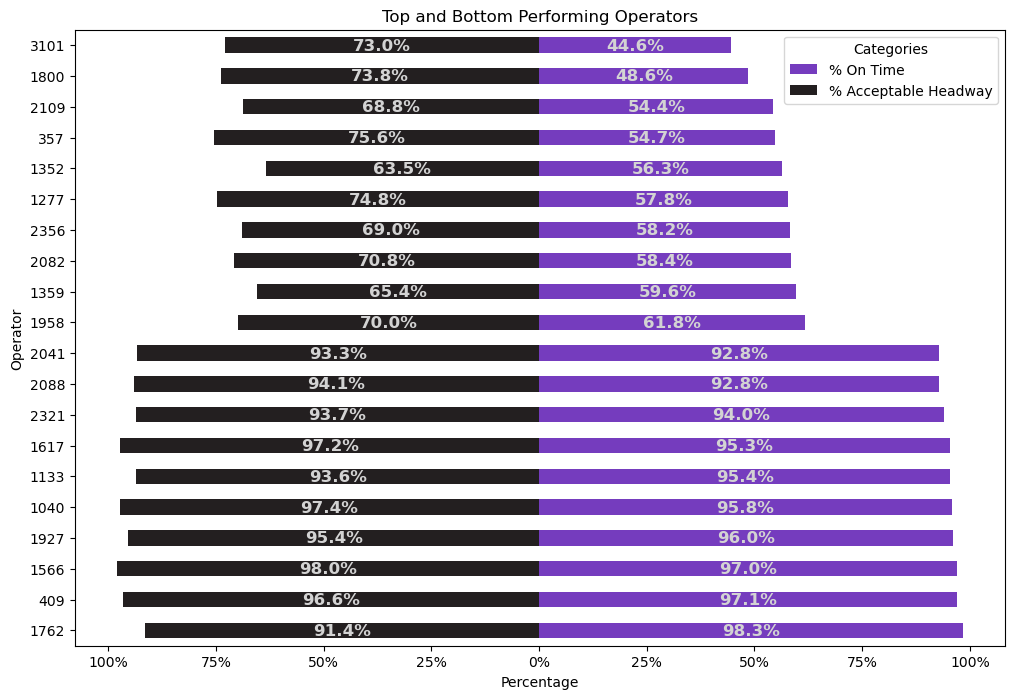

In [265]:
# fig = plt.figure()
# ax = fig.add_subplot(1,1,1)

# Graph Top and Bottom Operators
ax = top_bottom_operators[['ONTIME_PCT', 'NEGATIVE_ACCEPTABLE']].plot(kind='barh',
                                                                      stacked=True,
                                                                      figsize=(12, 8),
                                                                     color= [colors['p'], colors['b']])

ax.set(title = 'Top and Bottom Performing Operators',
        xlabel = 'Percentage',
       ylabel = 'Operator')

# set bar labels
for bar in ax.patches:
  ax.text(
      bar.get_x() + bar.get_width() / 2, # horizontal alignment
      bar.get_height() + bar.get_y() - 0.41, # vertical alignment
      get_label_value(bar.get_width()), # value
      ha='center', # Center the labels
      color=colors['g'], # style labels
      weight='bold',
      size=12
  )

ax.legend(bbox_to_anchor=(1, 1), title='Categories', labels = ['% On Time', '% Acceptable Headway'])
# Create custom percent labels
ax.set_xticklabels(['', '100%', '75%', '50%', '25%', '0%', '25%', '50%', '75%', '100%'])


# fig.savefig('../graphs/top_and_bottom_opperators_graph')